Quantum Random Walk
Designing the quantum walk operator for the case of a line topology with 16 nodes.

In [12]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences
size = 4 # Number of qubits to represent the nodes
num_nodes = 2**size # Total number of nodes (16 nodes)


The algorithm will include two operators:

Walk Operator: determines the walker's movement probabilities.
Shift Operator: perform the movement

walk Operator
The walk operator, determines the walker's movement probabilities. The walk operator transforms the walker 
state by assigning amplitudes to move left or right from each node. It checks the probobality of moving to adjacent nodes either left or right from the current state based on probability. if the probability of left node is more then it moves to left node and vice versa.



In [13]:
#The prepare_minus function prepares qubits in the ∣−⟩ state, necessary for initializing the auxiliary qubit used in interference.
@qfunc
def prepare_minus(x: QBit):

    X(x)
    H(x)

#The diffuzer_oracle function implements an oracle used in Grover's algorithm, aiding in the amplification of the probability of the desired state.
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    
    aux^=(x!=0)

#The zero_diffuzer function combines prepare_nimus function and diffuser_oracle function to apply the diffuser oracle to the auxiliary qubit.
@qfunc
def zero_diffuzer(x: QNum):

    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)
    
#The W_iteration function defines how the walker moves from one node to another based on set probabilities and handles quantum interference.
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):

    prob = [0]*num_nodes  # Initialize probability vector for 16 nodes
    if i == 0:
        prob[i + 1] = 1.0  # If at the first node, move to the right node (node 1)
    elif i == num_nodes - 1:
        prob[i - 1] = 1.0  # If at the last node, move to the left node (node 14)
    else:
        prob[i - 1] = 0.5  # Probability of moving to the left node
        prob[i + 1] = 0.5  # Probability of moving to the right node
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

#The W_operator function applies this walk operation across all nodes, enabling the full execution of the quantum walk across the graph.
@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):

    for i in range(num_nodes):
        W_iteration(i,vertices,adjacent_vertices)


Shift Operator Explanation
Once we have the movement probabilities, we use the shift operator to execute the perform movement. This operator swaps the walker's state between nodes based on the amplitudes set by the walk operator.


In [14]:
#edge_oracle: Determines if two vertices are adjacent by checking their difference.
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):

    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

#bitwise_swap: Swaps the values of two quantum arrays bit by bit, ensuring that the state of one vertex is exchanged with the state of another.

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
     repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 
    
#S_operator: Applies the shift operation by using the adjacency information from edge_oracle and performs the swap if the vertices are adjacent.

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):

    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))


In [ ]:
Putting them together
Let's put all these together to form a quantum walk.

The process begins by initializing the walker in a superposition of all possible positions along the line.
This is typically achieved using quantum gates, such as the Hadamard gate, which creates an equal probability amplitude for the walker
to be found at any of the 16 nodes. In mathematical terms, the walker's 
initial state can be represented as a superposition of basis states ∣0⟩, ∣1⟩,..., ∣15⟩,
where each basis state corresponds to one of the nodes.

In [15]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
# The below functions allocates the current node then applies Hadamard transform to initialize superposition and allocate adjacent vertices to perform walk
    allocate(size, vertices)  
    hadamard_transform(vertices)  # Apply Hadamard transform to initialize superposition
    allocate(size, adjacent_vertices)  # Allocate qubits for adjacent vertices
    
    W_operator(vertices, adjacent_vertices)  
    S_operator(vertices, adjacent_vertices)  


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)


Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

The screenshot of the circuit output:
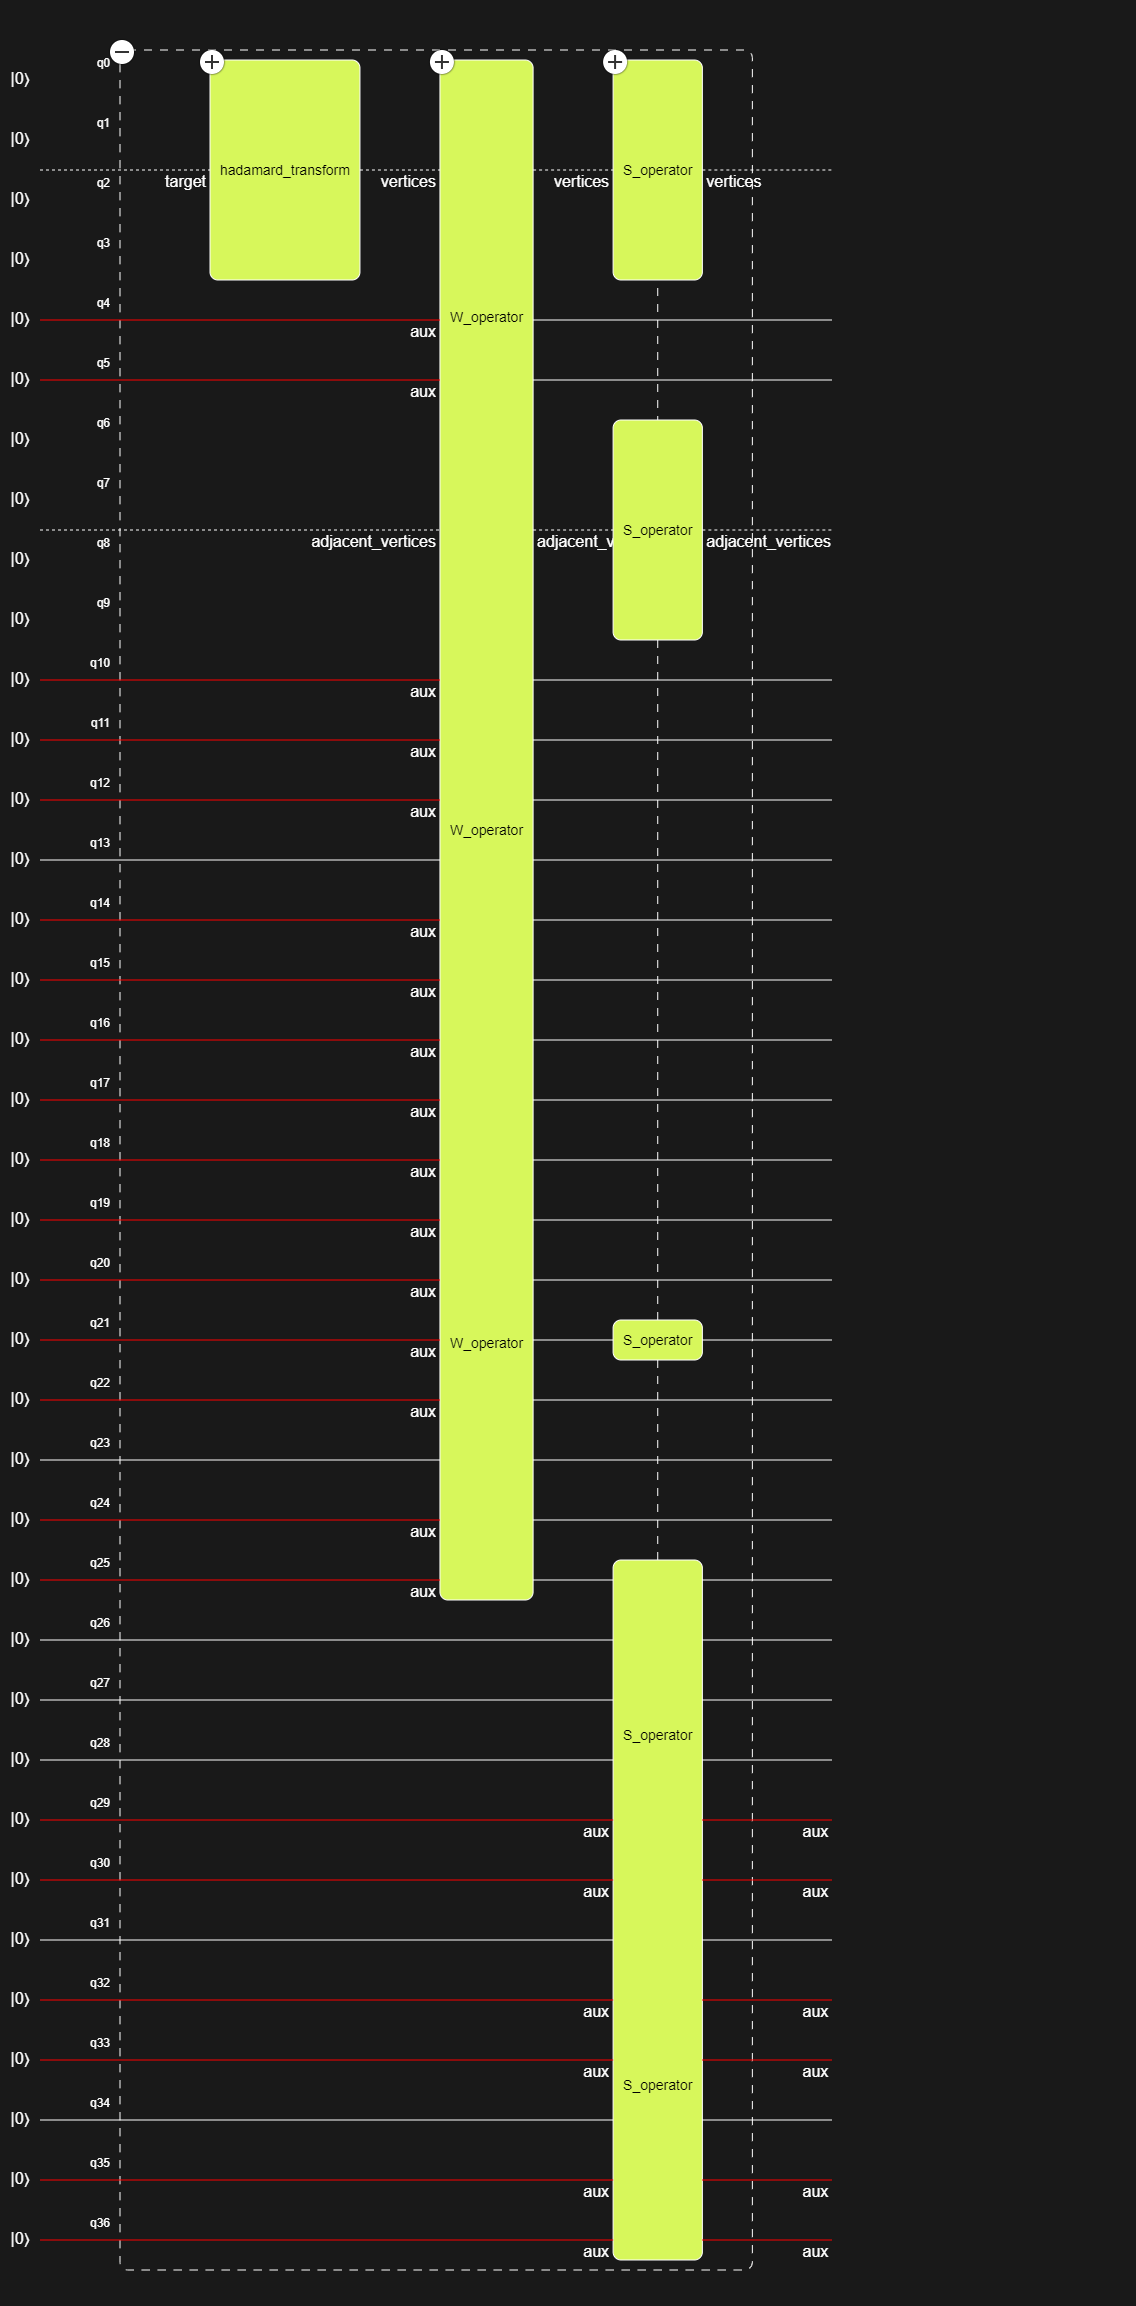
The circuit begins with the application of Hadamard gates to creates an equal superposition of all possible states, allowing the walker to have a non-zero probability of being at any of the 16 nodes

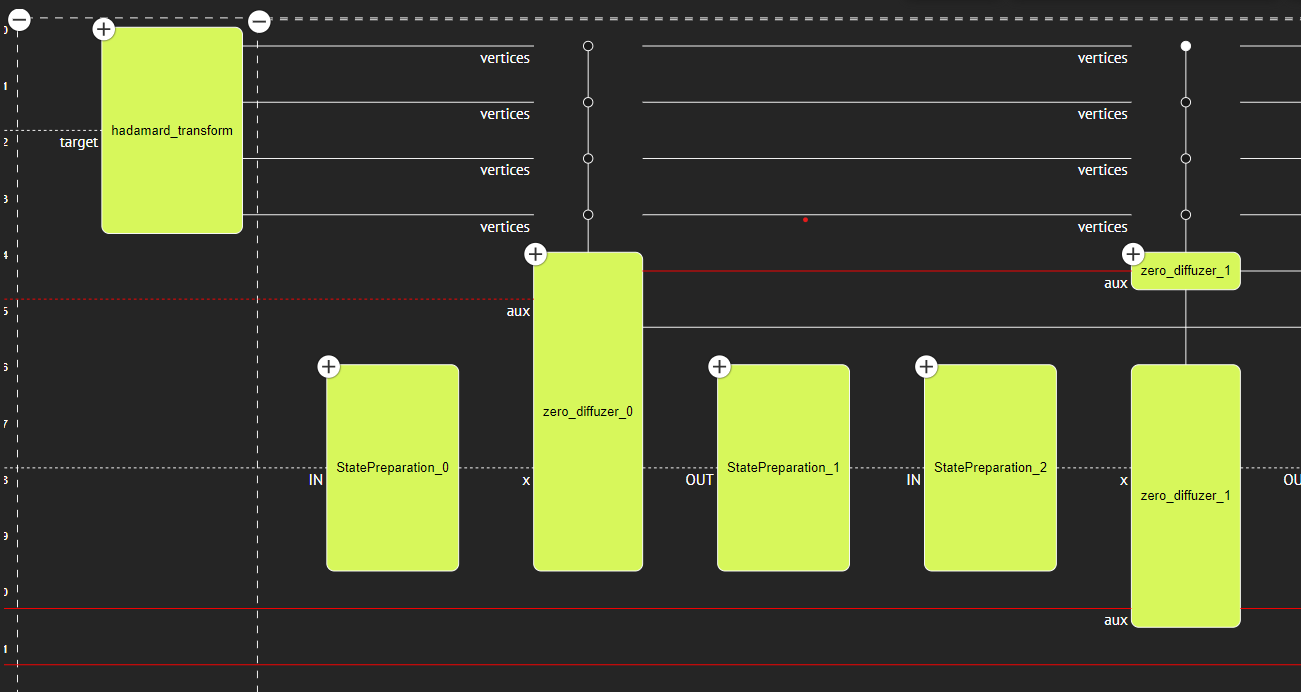

The above screenshot shows the implementation of walk operator function where it prepare the state and implements zero_diffuser function. State preparation block prepares the probabilities for moving to adjacent vertices. For each node, this function sets the probability amplitudes for the walker to move to its neighboring nodes. Zero diffuser block applies the diffusion operator to ensure that the probabilities are correctly distributed. The auxiliary qubit (aux) is used to facilitate this operation. The operations are applied sequentially to each node.


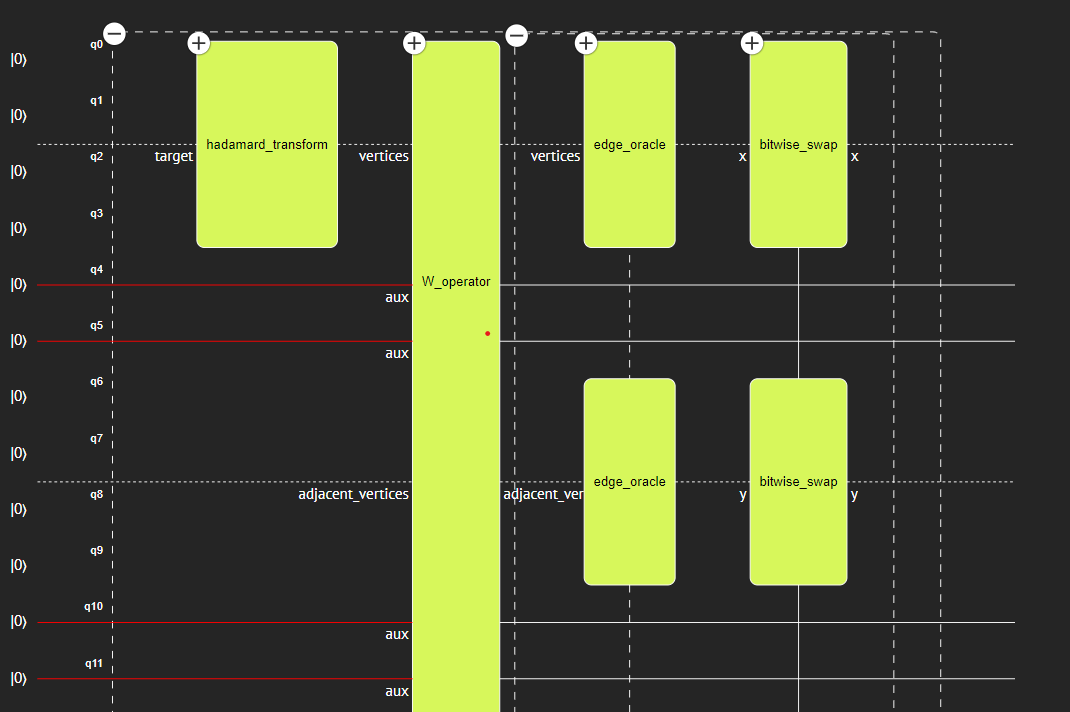
The above screenshot depicts how Shift operator is being implemented. The edge_oracle function block checks if two vertices are adjacent by checking their difference and the bitwise_swap performs the movement by swaping the state i.e it performs the movement.
